<a href="https://colab.research.google.com/github/RuthBiney/Chatbot_Summative_Assessment-/blob/main/Chatbot_Summative.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

###INTRODUCTION

# Chatbot Using Transformers (BERT)

## Introduction and Objective
The goal of this project is to create a chatbot using a transformer model, specifically BERT, for natural language understanding and response generation. The chatbot is designed to comprehend user queries and provide relevant responses by leveraging pre-trained models and fine-tuning techniques in natural language processing (NLP).

## Assignment Requirements
This project involves the following key tasks:
1. **Dataset Preparation:** Collect or create a dataset consisting of conversational pairs (user input and corresponding responses) to be used for training the chatbot.
2. **Data Preprocessing:** Prepare the dataset by tokenizing, normalizing, and formatting it for input into the BERT model.
3. **Model Fine-Tuning:** Use the BERT model and fine-tune it on the prepared conversational dataset to improve the chatbot's ability to generate relevant, human-like responses.
4. **Hyperparameter Tuning:** Experiment with different hyperparameters to optimize the model's performance.
5. **Evaluation:** Assess the chatbot's performance using metrics such as accuracy and F1 score, and conduct qualitative evaluations by testing the chatbot's responses to various user inputs.
6. **Interface Creation:** Develop a simple interface (command-line, mobile, or web-based) that allows users to interact with the chatbot easily.
7. **Documentation:** Document the entire development process, including the dataset, model architecture, challenges faced, performance metrics, and examples of chatbot interactions.


## Step 1: Dataset Loading and Preprocessing

In this step, we start by loading the BERT tokenizer and the pre-trained BERT model. The purpose of using a pre-trained model like BERT is to leverage its language understanding capabilities, which have been trained on a vast amount of text data. This provides a strong foundation for fine-tuning the model on a specific task, such as building a chatbot.

### Explanation of the Code:
1. **Loading the BERT Tokenizer:**
   - The tokenizer is used to preprocess the text data by converting words into tokens that BERT understands.
   - We use the `BertTokenizer.from_pretrained('bert-base-uncased')` to load the tokenizer with the 'bert-base-uncased' configuration. This configuration refers to a lowercased version of BERT, meaning that all text will be converted to lowercase during tokenization, which helps reduce the vocabulary size and improve processing efficiency.

2. **Loading the Pre-trained BERT Model:**
   - The `BertModel.from_pretrained('bert-base-uncased')` loads the pre-trained BERT model.
   - This model serves as a foundation for the chatbot. It has already learned various language patterns from a large corpus of text and can now be fine-tuned on the specific conversational dataset for better response generation.
   
3. **LabelBinarizer Import:**
   - Although the `LabelBinarizer` is imported, it will be used later in the notebook for converting text labels into a numerical format suitable for model training, especially if we use labeled responses.


In [1]:
from transformers import BertTokenizer, BertModel
from sklearn.preprocessing import LabelBinarizer

# Load the BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Import BERT-base pretrained model
bert_model = BertModel.from_pretrained('bert-base-uncased')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

In [2]:
import numpy as np
import pandas as pd
import re
import random
import transformers
import matplotlib.pyplot as plt
import json
import pickle
import torch

import nltk
nltk.download('punkt')
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Activation,Dropout
from tensorflow.keras.optimizers import SGD
from tensorflow.keras import metrics
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import load_model

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


In [3]:
df = pd.read_csv("/content/crop_diseases.csv")
df.head()

,Questions,Answers,Patterns,Tags
0,What is crop rotation?,Crop rotation is the practice of growing diffe...,Can you explain the concept of crop rotation?,Crop Rotation
1,What is the primary benefit of crop rotation?,The primary benefit of crop rotation is the im...,Why is crop rotation beneficial?,Soil Health
2,What is a cover crop?,A cover crop is a plant grown primarily to pro...,What is the purpose of a cover crop?,Cover Crops
3,What are common cover crops?,"Common cover crops include clover, rye, and ve...",Can you name some examples of cover crops?,Crop Examples
4,What is monoculture?,Monoculture is the agricultural practice of gr...,What does monoculture mean?,Monoculture


##Step 2: Creating the Intents Dictionary

Purpose:
The goal of this step is to convert raw data from your DataFrame into a structured format (JSON) that is suitable for training a chatbot. This format typically includes intents, which consist of:

#####Tags: Labels that categorize the intents.
#####Patterns: Variations of user input that the chatbot should recognize.
#####Responses: Answers the chatbot should provide when a specific intent is matched.

In [4]:

# Creating intents dictionary
dict_ = {"intents": []}

for ind in df.index:
    questions = df['Questions'][ind].lower().replace('?', '.').split('.')
    patterns = [q.strip() for q in questions if q.strip()]
    patterns.append(df['Patterns'][ind].lower().strip())
    responses = df['Answers'][ind]
    tag = df['Tags'][ind]

    dict1 = {'tags': [tag], 'patterns': patterns, 'responses': [responses]}
    dict_['intents'].append(dict1)

print(dict_["intents"][:2])

with open("crops.json", "w") as f:
    json.dump(dict_, f)

[{'tags': ['Crop Rotation'], 'patterns': ['what is crop rotation', 'can you explain the concept of crop rotation?'], 'responses': ['Crop rotation is the practice of growing different types of crops in the same area in sequential seasons to improve soil health and reduce pests.']}, {'tags': ['Soil Health'], 'patterns': ['what is the primary benefit of crop rotation', 'why is crop rotation beneficial?'], 'responses': ['The primary benefit of crop rotation is the improvement of soil fertility and the reduction of soilborne diseases and pests.']}]


##Step: Text Data Preprocessing and Feature Extraction
Purpose:
The goal of this code segment is to:

#####Tokenize and lemmatize the patterns from your intents.
#####Prepare a list of unique words and classes (tags) for training a model.
#####Generate embeddings for sentences (using BERT).

In [5]:
words=[]
classes=[]
documents=[]
ignore_letters=['?','!','.',',']
lemmatizer = WordNetLemmatizer()

# for intent in dict_['intents']:
#   for pattern in intent['patterns']:
#     if isinstance(pattern, str):
#       pattern = pattern.strip()
#       word_list = tokenizer(pattern)
#       words.extend(word_list)
#       documents.append((pattern, intent['tags']))
#       if intent['tags'] not in classes:
#         classes.append(intent['tags'])

# lemmatizer=WordNetLemmatizer()

# words = [lemmatizer.lemmatize(word.lower()) for word in words if word not in ignore_letters]
# words = sorted(set(words))
# classes = sorted(set(classes))

# pickle.dump(words, open('words.pkl', 'wb'))
# pickle.dump(classes, open('classes.pkl', 'wb'))

def get_bert_embedding(sentence):
    inputs = tokenizer(sentence, return_tensors='pt', padding=True, truncation=True)
    with torch.no_grad():
        outputs = bert_model(**inputs)
    return outputs.last_hidden_state.mean(dim=1).detach().numpy()

for intent in dict_['intents']:
    for pattern in intent['patterns']:
        if isinstance(pattern, str):
            word_list = tokenizer.tokenize(pattern)
            words.extend(word_list)
            documents.append((pattern, intent['tags'][0]))
            if intent['tags'][0] not in classes:
                classes.append(intent['tags'][0])

words = [lemmatizer.lemmatize(word.lower()) for word in words if word not in ignore_letters]
words = sorted(set(words))
classes = sorted(set(classes))

pickle.dump(words, open('words.pkl', 'wb'))
pickle.dump(classes, open('classes.pkl', 'wb'))

##Step: Prepare Training Data
Purpose:
The purpose of this step is to prepare the input data (features) and output data (labels) in a format suitable for training a machine learning model. This includes generating BERT embeddings for each pattern and converting the corresponding tags into a one-hot encoded format.

In [6]:
# # Prepare training data
# training = []
# output_empty = [0] * len(classes)
# label_binarizer = LabelBinarizer()
# label_binarizer.fit(classes)

# for document in documents:
#   pattern = document[0]
#   tag = document[1]
#   # tokenize & convert to BERT embeddings
#   inputs = tokenizer(pattern, return_tensors='pt', padding=True, truncation=True)
#   with torch.no_grad():
#     outputs = model(**inputs)
#   embeddings = outputs.last_hidden_state.mean(dim=1).detach().numpy()
#   output_row = label_binarizer.transform([tag])[0]
#   # print(output_row)
#   training.append((embeddings.flatten(), output_row))

# # print(training)
# # Shuffle and prepare the training data
# random.shuffle(training)
# training = np.array(training, dtype=object)

# train_x = np.array([item[0] for item in training])
# train_y = np.array([item[1] for item in training])


# Prepare training data
training = []
output_empty = [0] * len(classes)
label_binarizer = LabelBinarizer()
label_binarizer.fit(classes)

for document in documents:
    pattern = document[0]
    tag = document[1]
    embedding = get_bert_embedding(pattern)
    output_row = label_binarizer.transform([tag])[0]
    training.append((embedding.flatten(), output_row))

random.shuffle(training)
training = np.array(training, dtype=object)

train_x = np.array([item[0] for item in training])
train_y = np.array([item[1] for item in training])

##Step: Building and Compiling the Neural Network Model
Purpose:
The purpose is to design a feedforward neural network architecture for classifying user queries (text inputs) into different intent categories and set up the optimizer and evaluation metrics for training the model.

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 128)                 │          98,432 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 38)                  │           2,470 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 109,158 (426.40 KB)

 Trainable params: 109,158 (426.40 KB)

 Non-trainable params: 0 (0.00 B)

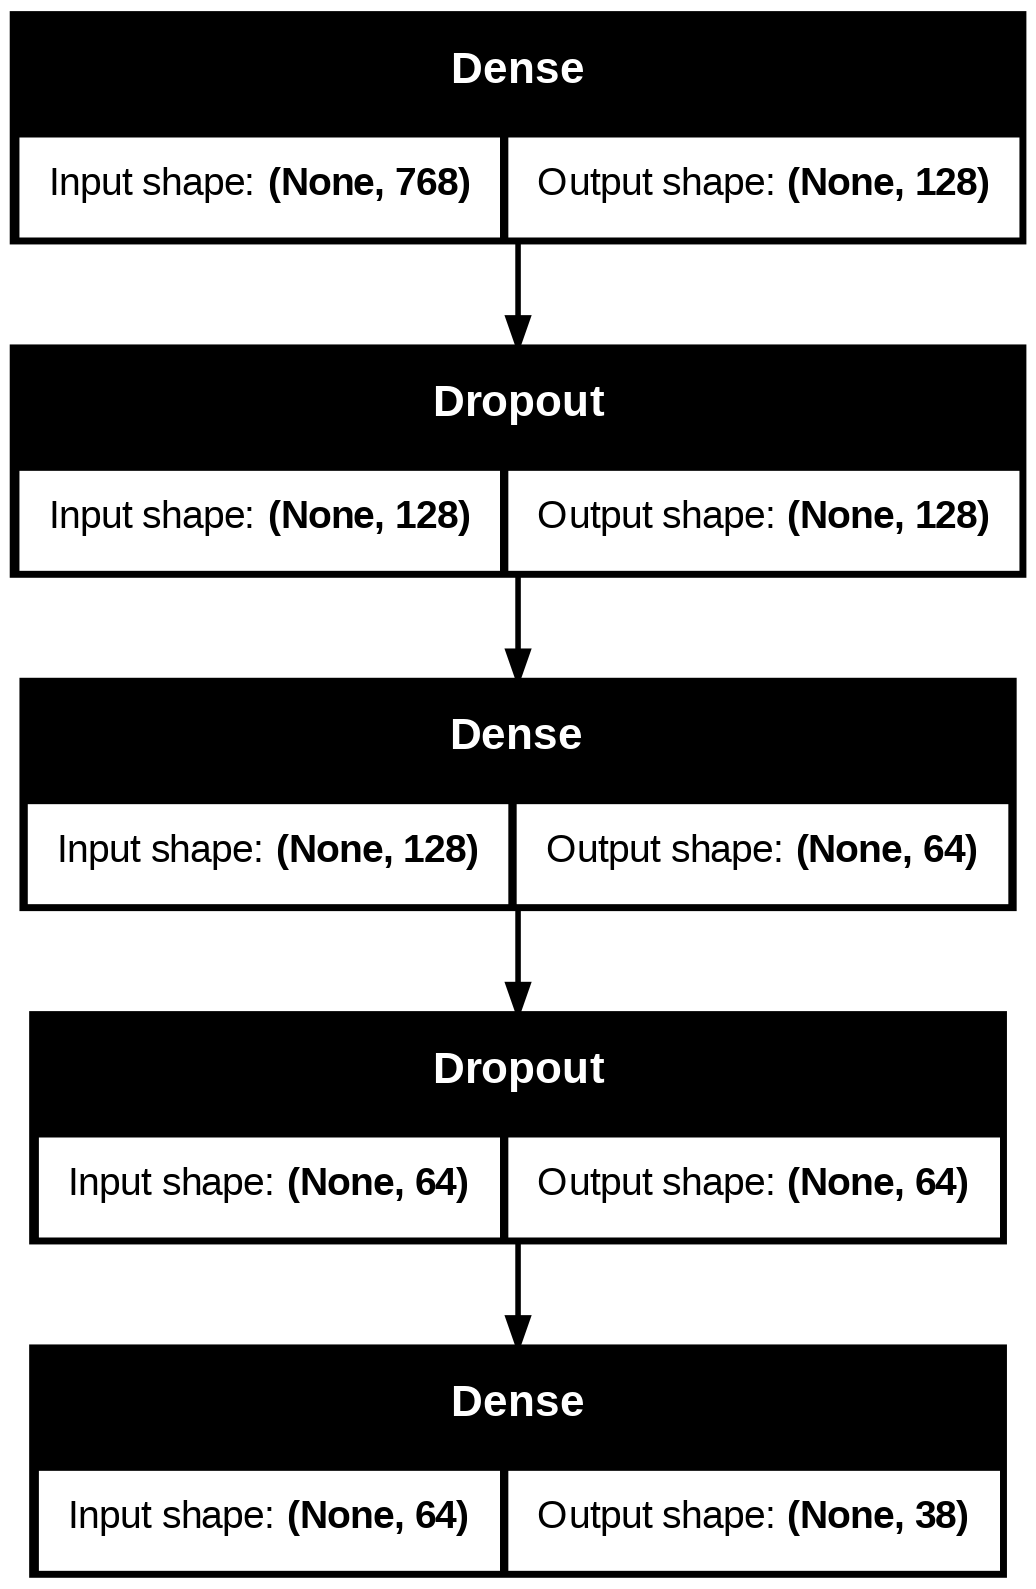

In [7]:
from tensorflow.keras.optimizers.schedules import ExponentialDecay

model=Sequential()
model.add(Dense(128,input_shape=(len(train_x[1]),),activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(64,activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(len(train_y[0]),activation='softmax'))


# Define learning rate schedule
lr_schedule = ExponentialDecay(
    initial_learning_rate=0.0001,
    decay_steps=100000,
    decay_rate=0.96,
    staircase=True
)

# Use the SGD optimizer with the learning rate schedule
sgd = SGD(learning_rate=lr_schedule, momentum=0.9, nesterov=True)
# sgd=SGD(learning_rate=0.0001,decay=1e-6,momentum=0.9,nesterov=True)


model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy','Precision','Recall'])
# model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=METRICS)
model.summary()
plot_model(model, to_file='model.png', show_shapes=True)


##Step: Model Training and Saving
Purpose:
The code trains the neural network using the training data (train_x and train_y), saves the trained model to a file, and prints a message indicating that the training is finished.

In [8]:
hist = model.fit(np.array(train_x),np.array(train_y),epochs=50,batch_size=12,verbose=1)
model.save('chatbotmodel.h5', hist)
print('Training Done')

Epoch 1/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - Precision: 0.0000e+00 - Recall: 0.0000e+00 - accuracy: 0.0303 - loss: 3.6779
Epoch 2/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Precision: 0.0000e+00 - Recall: 0.0000e+00 - accuracy: 0.0318 - loss: 3.5543 
Epoch 3/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Precision: 0.0000e+00 - Recall: 0.0000e+00 - accuracy: 0.1420 - loss: 3.4978 
Epoch 4/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Precision: 0.0000e+00 - Recall: 0.0000e+00 - accuracy: 0.2111 - loss: 3.3120  
Epoch 5/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Precision: 0.0000e+00 - Recall: 0.0000e+00 - accuracy: 0.1631 - loss: 3.1908 
Epoch 6/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Precision: 0.0000e+00 - Recall: 0.0000e+00 - accuracy: 0.2565 - loss: 2.9897 
Epoch 7/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Precision: 0.0000e+00 - Recall: 0.0000e+00 - accuracy: 0.2759 - loss: 2.7515 
Epoch 8/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Precision: 0.0000e+00 - Recall: 0.0000e+00 - accuracy:

Training Done


##Step: Visualizing Training Performance
Purpose:
The code uses Matplotlib to plot the model's accuracy and loss values recorded during training. This provides a visual representation of how the model's performance improves (or potentially deteriorates) over the course of the training epochs.

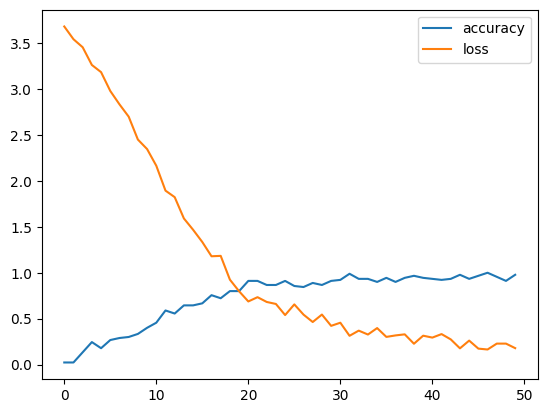

In [9]:
plt.plot(hist.history['accuracy'],label='accuracy')
plt.plot(hist.history['loss'],label='loss')
# plt.show()
plt.legend()

##Step: Model Loading, Prediction, and Response
Purpose:
The code loads the pre-trained chatbot model, uses it to classify user input into intents, and generates responses based on the predicted intent.

In [ ]:
# Load the model for prediction
model = load_model('chatbotmodel.h5')

def predict_class(sentence):
    embedding = get_bert_embedding(sentence)
    res = model.predict(embedding)[0]
    ERROR_THRESHOLD = 0.25
    results = [[i, r] for i, r in enumerate(res) if r > ERROR_THRESHOLD]
    results.sort(key=lambda x: x[1], reverse=True)
    return_list = [{'intent': classes[r[0]], 'probability': str(r[1])} for r in results]
    return return_list

def get_response(intents_list, intents_json):
    tag = intents_list[0]['intent']
    for i in intents_json['intents']:
        if tag in i['tags']:
            return random.choice(i['responses'])
    return "Sorry, I don't understand."

print("GO! BOT IS RUNNING")

while True:
    message = input("")
    if message.lower() in ['quit', 'exit']:
        print("Goodbye")
        break
    ints = predict_class(message)
    if ints:
        res = get_response(ints, dict_)
        print(f"Bot: {res}")
    else:
        print("Bot: Sorry, I don't understand.")

GO! BOT IS RUNNING
What is the primary benefit of crop rotation?
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
Bot: The primary benefit of crop rotation is the improvement of soil fertility and the reduction of soilborne diseases and pests.
